## 这是我的transformer的学习笔记，我将要实现三个任务，情感分类，命名个体识别，还有就是我的decoder—only模型来进行文本的生成

## Text classification

### 使用IMdb影音评论数据

In [ ]:
!pip install datasets

In [40]:
from datasets import load_dataset

In [41]:
dataset = load_dataset("imdb")

In [42]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [ ]:
print(dataset["train"][0])

In [44]:
from transformers import AutoTokenizer, AutoModel

In [45]:
train_data = dataset["train"]
test_data = dataset["test"]
unsupervised_data = dataset["unsupervised"]

In [46]:
print(train_data)
print(test_data)
print(unsupervised_data)

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 50000
})


In [ ]:
print(train_data["text"][0])

In [48]:
print(train_data["label"][0])

0


In [ ]:
print(unsupervised_data["text"][0])

In [50]:
print(unsupervised_data["label"][0])

-1


In [53]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenized(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

train_data = train_data.map(tokenized, batched=True)
test_data = test_data.map(tokenized, batched=True)
unsupervised_data = unsupervised_data.map(tokenized, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [54]:
print(train_data)

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 25000
})


In [55]:
print(test_data)

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 25000
})


In [56]:
print(unsupervised_data)

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 50000
})


In [ ]:
# CUDA 12.1（推荐）
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [58]:
import torch

print(torch.__version__)
print(torch.cuda.is_available())
train_data.set_format(type="torch", columns=["label", "input_ids", "attention_mask"])
test_data.set_format(type="torch", columns=["label", "input_ids", "attention_mask"])
unsupervised_data.set_format(type="torch", columns=["label", "input_ids", "attention_mask"])

2.5.1+cu121
True


In [59]:
from torch.utils.data import DataLoader

In [60]:
train_data_loader = DataLoader(train_data, batch_size=24, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=24, shuffle=False)
unsupervised_data_loader = DataLoader(unsupervised_data, batch_size=24, shuffle=True)

In [61]:
import torch.nn as nn

In [74]:
class MyBert(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_labels=2):
        super().__init__()
        self.bert = AutoModel.from_pretrained("bert-base-uncased")
        self.last_layer = nn.Linear(in_features=self.bert.config.hidden_size, out_features=num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask= attention_mask)
        cls_output = outputs.pooler_output
        return self.last_layer(cls_output)

In [75]:
device ="cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [76]:
from tqdm import tqdm

In [77]:
model = MyBert()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()


model.to(device)
model.train()
for epoch in range(3):
    for batch in tqdm(train_data_loader, desc=f"epoch{epoch+1}"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        label = batch["label"].to(device)
        
        output = model(input_ids, attention_mask)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

epoch3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1042/1042 [05:06<00:00,  3.40it/s]


In [78]:
!pip install scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [79]:
from sklearn.metrics import f1_score, classification_report

In [80]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        #extend是把一个对象拆开，每一项放入列表中
        #append是把一个对象直接放入列表中
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

f1score = f1_score(all_labels, all_preds, average="macro")
classification_repo = classification_report(all_labels, all_preds)

In [83]:
print(f"f1_score {f1score}")
print(classification_repo)

f1_score 0.8881850577667356
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     12500
           1       0.88      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



In [84]:
torch.save(model.state_dict(), "my_custom_model.pt")
tokenizer.save_pretrained("mybert_tokenizer/")

('mybert_tokenizer/tokenizer_config.json',
 'mybert_tokenizer/special_tokens_map.json',
 'mybert_tokenizer/vocab.txt',
 'mybert_tokenizer/added_tokens.json',
 'mybert_tokenizer/tokenizer.json')

In [ ]:
!pip install gradio

In [5]:
import torch 
from torch import nn as nn
import gradio as gr
from transformers import AutoTokenizer, AutoModel

In [ ]:
class MyBert(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_labels=2):
        super().__init__()
        self.bert = AutoModel.from_pretrained("bert-base-uncased")
        self.last_layer = nn.Linear(in_features=self.bert.config.hidden_size, out_features=num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask= attention_mask)
        cls_output = outputs.pooler_output
        return self.last_layer(cls_output)


device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained("mybert_tokenizer")
model = MyBert()
model.load_state_dict(torch.load("my_custom_model.pt", map_location=device))
model.to(device)
model.eval()

In [7]:
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", max_length=128, padding="max_length",truncation=True)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        logistics = model(input_ids, attention_mask)
        result = torch.argmax(logistics, dim=1).item()

    return "positive" if result == 1 else "negative"

In [ ]:
gr.Interface(
    fn = predict,
    inputs = gr.Textbox(label="please gives your text"),
    outputs = gr.Textbox(label="motion classification"),
    title = "Movie comment classification",
    description ="base on gradio, and from base-bert" 
).launch(inline=True, share=True)

### This is the end of Text classification(binary)

### 现在我们进行文本的多分类任务，使用AGnews这个数据集

In [1]:
from datasets import load_dataset

In [2]:
dataset = load_dataset("ag_news")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


In [8]:
print(dataset["train"].features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)}


In [3]:
train_data = dataset["train"]
test_data = dataset["test"]

In [6]:
print(dataset["train"]["label"][:20])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [4]:
print(dataset["train"].features["label"])

ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)


In [5]:
print(train_data)

Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})


In [6]:
print(train_data.features["label"])

ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)


### 得到了我们需要做的四个分类任务

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [8]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def tokenize(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)


train_data = train_data.map(tokenize, batched=True)
test_data = test_data.map(tokenize, batched=True)

In [10]:
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [11]:
from torch.utils.data import DataLoader
import torch

train_data_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [12]:
from torch import nn as nn
import numpy as np
from tqdm import tqdm
import os

In [13]:
from collections import Counter

all_labels = [int(x["label"]) for x in dataset["train"]]
print("标签计数:", Counter(all_labels))
print("最大值:", max(all_labels))


标签计数: Counter({2: 30000, 3: 30000, 1: 30000, 0: 30000})
最大值: 3


In [ ]:
print(device)

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
model.to(device)

model.train()

for epoch in range(3):
    mean_loss = []
    for batch in tqdm(train_data_loader, desc=f"epoch{epoch + 1}"):
        optimizer.zero_grad()
        
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
        label = batch["label"].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=label)
        
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        mean_loss.append(loss.item())
    meanloss = np.mean(mean_loss)
    print(f"meanloss:{meanloss}")

epoch1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [21:41<00:00,  1.44it/s]


meanloss:0.24492207316160203


epoch2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [21:36<00:00,  1.45it/s]


meanloss:0.1477492218752702


epoch3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [21:35<00:00,  1.45it/s]

meanloss:0.11162248419821262


In [ ]:
model.save_pretrained("bert_multi_classification")

In [28]:
tokenizer.save_pretrained("bert_multi_classification")

('bert_multi_classification\\tokenizer_config.json',
 'bert_multi_classification\\special_tokens_map.json',
 'bert_multi_classification\\vocab.txt',
 'bert_multi_classification\\added_tokens.json',
 'bert_multi_classification\\tokenizer.json')

In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [20]:
!pip install protobuf --upgrade


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert_multi_classification")
tokenizer = AutoTokenizer.from_pretrained("bert_multi_classification")
model.to(device)
model.eval()

In [50]:
import torch

In [51]:
classification = {0:'World', 1:'Sports', 2:'Business', 3:'Sci/Tech'}

In [59]:
def predict_bert_muti(text):
    input = tokenizer(text, padding="max_length", max_length=128, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**input)
        logits = outputs.logits
        predict = torch.argmax(logits, dim=1).item()
        return classification[predict]

In [60]:
import gradio as gr

In [ ]:
gr.Interface(
    fn = predict_bert_muti,
    inputs = gr.Textbox(label="input the news"),
    outputs = gr.Textbox(label="type"),
    title = "news classification"
).launch(inline=True)

### This is the end of Text classification(mutilpul)

### 现在我们来进行命名实体识别任务，使用CoNLL-2003数据集进行练习

In [7]:
from datasets import load_dataset

In [8]:
dataset = load_dataset("conll2003")

In [9]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


In [10]:
print(dataset["train"].features["ner_tags"])

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)


In [11]:
print(dataset["train"]["tokens"][0])

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']


In [12]:
print(dataset["train"]["ner_tags"][0])

[3, 0, 7, 0, 0, 0, 7, 0, 0]


In [13]:
from transformers import AutoTokenizer

In [14]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [15]:
# lets have a look of tokenized
tokenized_data = tokenizer(dataset["train"]["tokens"][0], truncation=True, is_split_into_words=True)
print(tokenized_data)
# looks like the output likes before

{'input_ids': [101, 7270, 22961, 1528, 1840, 1106, 21423, 1418, 2495, 12913, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [70]:
tokenized_data = tokenizer(dataset["train"]["tokens"][0], truncation=True, is_split_into_words=True, return_tensors="pt").to("cuda")
print(tokenized_data)

{'input_ids': tensor([[  101,  7270, 22961,  1528,  1840,  1106, 21423,  1418,  2495, 12913,
           119,   102]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}


In [43]:
# Also take a look at word_ids
print(tokenized_data.word_ids())

[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]


In [44]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    all_labels = []

    for i, labels in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(labels[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx

        all_labels.append(label_ids)
        
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

In [46]:
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)

In [67]:
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
print(tokenized_dataset)

In [69]:
print(tokenized_dataset["train"].features["ner_tags"])

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)


In [70]:
print(tokenized_dataset["train"].features["ner_tags"].feature)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None)


In [71]:
# use feature`s name parameter
print(tokenized_dataset["train"].features["ner_tags"].feature.names)

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


In [72]:
labels = tokenized_dataset["train"].features["ner_tags"].feature.names

In [2]:
from transformers import AutoModelForTokenClassification

In [74]:
model = AutoModelForTokenClassification.from_pretrained("bert-base-cased", num_labels = len(labels))

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

In [ ]:
from transformers import DataCollatorForTokenClassification


data_collator = DataCollatorForTokenClassification(tokenizer)

In [77]:
train_dataloader = DataLoader(tokenized_dataset["train"], batch_size=32, shuffle=True, collate_fn=data_collator)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):
    model.train()
    mean_loss = []
    for batch in tqdm(train_dataloader, desc=f"epoch {epoch + 1}"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        
        outputs = model(input_ids= input_ids, attention_mask = attention_mask, labels = labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        mean_loss.append(loss.item())
    mean_loss = np.mean(mean_loss)
    print(f"epoch {epoch + 1}mean_loss {mean_loss}")

epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 439/439 [01:18<00:00,  5.56it/s]


epoch 1mean_loss 0.11630485803822314


epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 439/439 [01:18<00:00,  5.59it/s]


epoch 2mean_loss 0.02696118588375823


epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 439/439 [01:18<00:00,  5.57it/s]

epoch 3mean_loss 0.014750645528038314


In [ ]:
model.save_pretrained("my_bert_ner")
tokenizer.save_pretrained("my_bert_ner")

In [61]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
from datasets import load_dataset

In [62]:
dataset = load_dataset("conll2003")
labels = dataset["train"].features["ner_tags"].feature.names
print(labels)

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("my_bert_ner")
model = AutoModelForTokenClassification.from_pretrained("my_bert_ner")


device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

In [ ]:
# load the model for visulize model output
with torch.no_grad():
    output = model(**tokenized_data)

print(output.logits)
print(output.logits.shape)
# it means 1 sentence, 12 tokens, 9 NERs

In [66]:
def prediction(text):
    tokenizerd_data = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():
        outputs = model(**tokenizerd_data)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=2)

    #为什么用第0个？
    #convert_ids_to_tokens只支持1维输入
    #输入一个句子，然后batchsize=1，所以直接取第一个就行
    #如果batchsize不为1，那么tokenizerd_data["input_ids"][i]
    token_decoded = tokenizer.convert_ids_to_tokens(tokenizerd_data["input_ids"][0])

    entities = []
    current_entity = {"word": "", "entity": ""}

    for token, label_idx in zip(token_decoded, predictions[0]):
        label = labels[label_idx.item()]

        if label == "O":
            if current_entity["word"]:
                entities.append((current_entity["word"], current_entity["entity"]))
                current_entity = {"word": "", "entity": ""}
            continue

        if label.startswith("B-"):
            if current_entity["word"]:
                entities.append((current_entity["word"], current_entity["entity"]))
            current_entity = {"word": token.replace("##", ""), "entity": label[2:]}

        elif label.startswith("I-") and current_entity["word"]:
            current_entity["word"] += token.replace("##", "")

    # 最后一个实体记得加进去
    if current_entity["word"]:
        entities.append((current_entity["word"], current_entity["entity"]))

    return {"text": text, "entities": [{"entity": ent[1], "word": ent[0]} for ent in entities]}


In [67]:
import gradio as gr

In [ ]:
gr.Interface(
    fn = prediction,
    inputs= gr.Textbox(lines=4, placeholder="please gives text"),
    outputs= gr.JSON()
).launch(inline=True)

### This is the end of NER task, The importance of NER is how to embedding the label, and how to deal with prediction functions

### 接下来进行我们的decoder-only模型的学习：

### 在这里面的学习中，我们首先使用我们的TinyLlama模型直接进行部署，不进行任何的微调，然后使用模型进行微调之后再次部署，最主要是要掌握decoder_only模型针对不同的任务的情况下应该使用什么样的预测函数，然后是如何使用这个预训练模型进行微调

### 首先是聊天机器人

In [29]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [30]:
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [31]:
import torch
import gradio as gr

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

In [43]:
chat_history = []

def predict_chat_box(user_input):
    chat_history.append(f"User: {user_input}")
    prompt = "\n".join(chat_history) + "\nAssistant:"

    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    input_ids = inputs["input_ids"].to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            max_new_tokens=150,
            do_sample=True,
            top_p=0.85,
            temperature=0.5
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = response[len(prompt):].strip()

    chat_history.append(f"Assistant: {response}")
    return response


In [ ]:
gr.Interface(
    fn=predict_chat_box,
    inputs=gr.Textbox(label="Chat here"),
    outputs=gr.Textbox(label="reply here")
).launch(inline=True)

### 可以看到，效果非常差，回复非常混乱

### 使用LORA微调

In [ ]:
!pip install peft 

In [2]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("json", data_files=r"tinyllama_finetune_data_diverse.jsonl")

In [4]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 100
    })
})


In [5]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import LoraConfig, TaskType, get_peft_model

In [14]:
def format_transform(dataset):
    
    prompt = f"### instruction:\n{dataset["instruction"]}\n\n### Response:\n{dataset["output"]}"

    return {"text": prompt}

In [ ]:
datasets_for_tokenizer = dataset.map(format_transform)

In [16]:
print(datasets_for_tokenizer)

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'text'],
        num_rows: 100
    })
})


In [33]:
def tokenize(dataset):
    
    return tokenizer(dataset["text"], padding="max_length", truncation=True, max_length=128)

In [39]:
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

In [35]:
inputs = datasets_for_tokenizer.map(tokenize, batched=True)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [36]:
print(inputs)

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'text', 'input_ids', 'attention_mask'],
        num_rows: 100
    })
})


In [37]:
import torch

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### 注意，因为我的这个大语言模型是decoder-only模型，所以说模型其实是根据左边的结果来预测右边，所以说我们要显式设置我们的模型的tokenizer从左边填充我们的模型，也就是在左边加[PAD],不然模型的任务就变成根据左边的真实的内容预测我们右边的[PAD]这个token了

In [ ]:
tokenizer.padding_side = "left"

In [40]:
model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0", device_map=device)

In [42]:
lora_config = LoraConfig(
    r = 8,
    lora_alpha=16,
    task_type=TaskType.CAUSAL_LM
)

model = get_peft_model(model, lora_config)

### 可以看到使用lora我们只需要训练很少的数据数量，仅仅为0.1%

In [43]:
model.print_trainable_parameters()

trainable params: 1,126,400 || all params: 1,101,174,784 || trainable%: 0.1023


In [47]:
from torch.optim import AdamW

### 现在有一个非常重要的问题：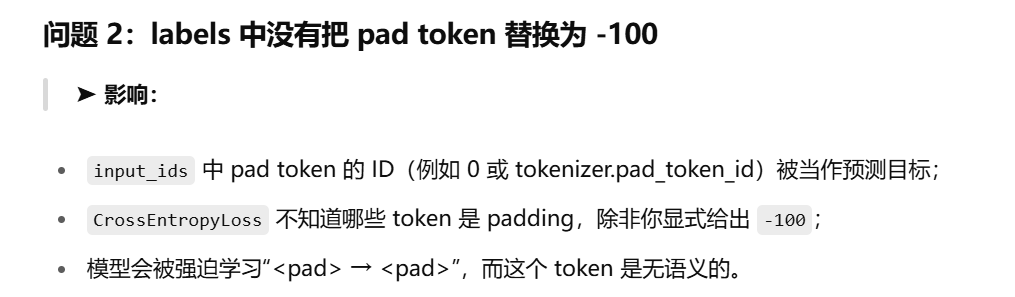

### 我们的模型经过了tokenize之后，得到了：`input_ids` `attention_mask`这两个东西，其中input_ids是我的输入的数据经过tokenizer分词并转换成tensor类型的结果，然后我的attention_mask决定我的模型训练的时候关注哪些东西，所以就算没有设置-100，但是我的attention_mask的作用下，我的模型并不会学习到错误的知识

## 但是！由于模型的优化器是根据模型的结果[labels] 来作为标准的答案，然后使用模型运行输入数据后得到的结果和这个标准结果进行比较然后计算loss优化我们的模型的，所以如果说没有设置为-100，在计算loss的时候会自动计算[PAD]的loss，这样会让我们的模型学习无用的信息，泛化能力也会下降

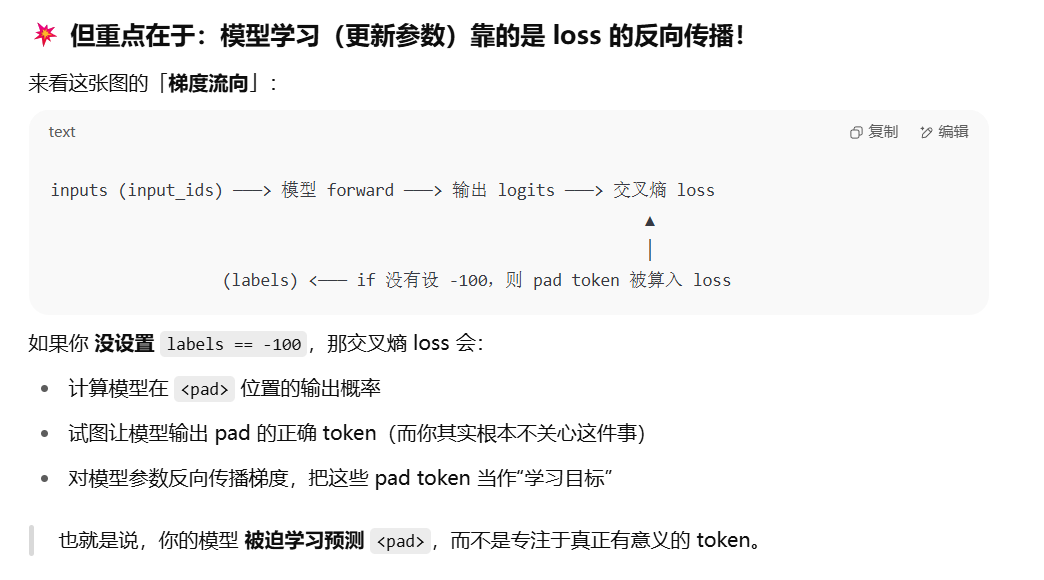

In [ ]:
def set_labels(example):
    input_ids = example["input_ids"].copy()
    pad_id = tokenizer.pad_token_id
    
    labels = [-100 if token_id == pad_id else token_id for token_id in input_ids]
    example["labels"] = labels
    
    return example
    

In [ ]:
inputs = inputs.map(set_labels)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
inputs.set_format("torch")

In [51]:
print(inputs)

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
})


In [52]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np


data_loader = DataLoader(inputs["train"], batch_size=16, shuffle=True)
optimizer = AdamW(model.parameters(), lr=2e-4)

epochs = 3
model.to(device)
model.train()

for epoch in range(epochs):
    loss_avr = []
    progress = tqdm(data_loader, desc=f"epoch {epoch + 1}")
    for batch in progress:
        optimizer.zero_grad()

        
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss_avr.append(loss.item())

        loss.backward()
        optimizer.step()

    
    
    print(f"loss for epoch {epoch+1} is {np.mean(loss_avr)}")

epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.44s/it]


loss for epoch 1 is 10.629281112125941


epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.34s/it]


loss for epoch 2 is 3.896667378289359


epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.38s/it]

loss for epoch 3 is 1.2305080550057548


In [53]:
model.save_pretrained("TinyLlama_lora_finetune")
tokenizer.save_pretrained("TinyLlama_lora_finetune")

('TinyLlama_lora_finetune\\tokenizer_config.json',
 'TinyLlama_lora_finetune\\special_tokens_map.json',
 'TinyLlama_lora_finetune\\chat_template.jinja',
 'TinyLlama_lora_finetune\\tokenizer.json')

In [69]:
# clean the using of GPU memory
torch.cuda.empty_cache()

In [79]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

In [80]:
model_id = "TinyLlama_lora_finetune/"

In [81]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# the tokenizer has no changed
tokenizer = AutoTokenizer.from_pretrained(model_id)
# need to use the original model to conbian with LoRA
model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0", device_map=device)
peft_model = PeftModel.from_pretrained(model, model_id)

In [ ]:
model.eval()

In [83]:
def chat_with_model(user_input, chat_history):
    prompt = ""

    for user, bot in chat_history:
        prompt += f"User :{user}\nAssistant: {bot}\n"
    prompt += f"User: {user_input}"
    prompt += f"Assistant: "

    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=True,
            temperature=0.7,
            top_p=0.9
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    latest_response = response.split("Assistant:")[-1].strip()

    chat_history.append((user_input, latest_response))

    return chat_history

In [89]:
def reset_history_of_gradio():
    return [], []

In [85]:
import gradio as gr

In [86]:
chat_history = []

In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("## This a demo of LoRa fine-tuning TinyLlama")
    
    chat_bot = gr.Chatbot()
    user_input = gr.Textbox(placeholder="please sign your inputs here")
    submit_button = gr.Button("send request")
    reset_history = gr.Button("reset history")

    state = gr.State([])
    
    submit_button.click(
        fn=chat_with_model,
        inputs=[user_input, state],
        outputs=chat_bot
    ).then(fn=lambda:"", inputs=[], outputs=user_input)

    reset_history.click(
        fn=reset_history_of_gradio,
        outputs=[chat_bot, state]
    )

demo.launch()

## 以上是传统的部署方法，看的出效果很烂，可以尝试使用ollama获取微调后的safetensor然后本地部署，方便又简单，只需调用api/chat，然后发送的数据是messages，接收的是message就行了

### 目前ollama不支持直接使用微调后的基础模型和LoRa进行加载，所以要先进行转换然后才能使用ollama加载模型，目前（2025-0705）我记得官方文档上说支持使用safetensors以及GGUF

### GGUF支持在小模型上部署并且进行量化，但是使用非常复杂，所以现在首先进行safetensors格式的学习

### 上面保存了我的模型以及LoRa的参数，格式是safetensors，查看Ollama的imports得知，加载safetensors模型在我的imorts中

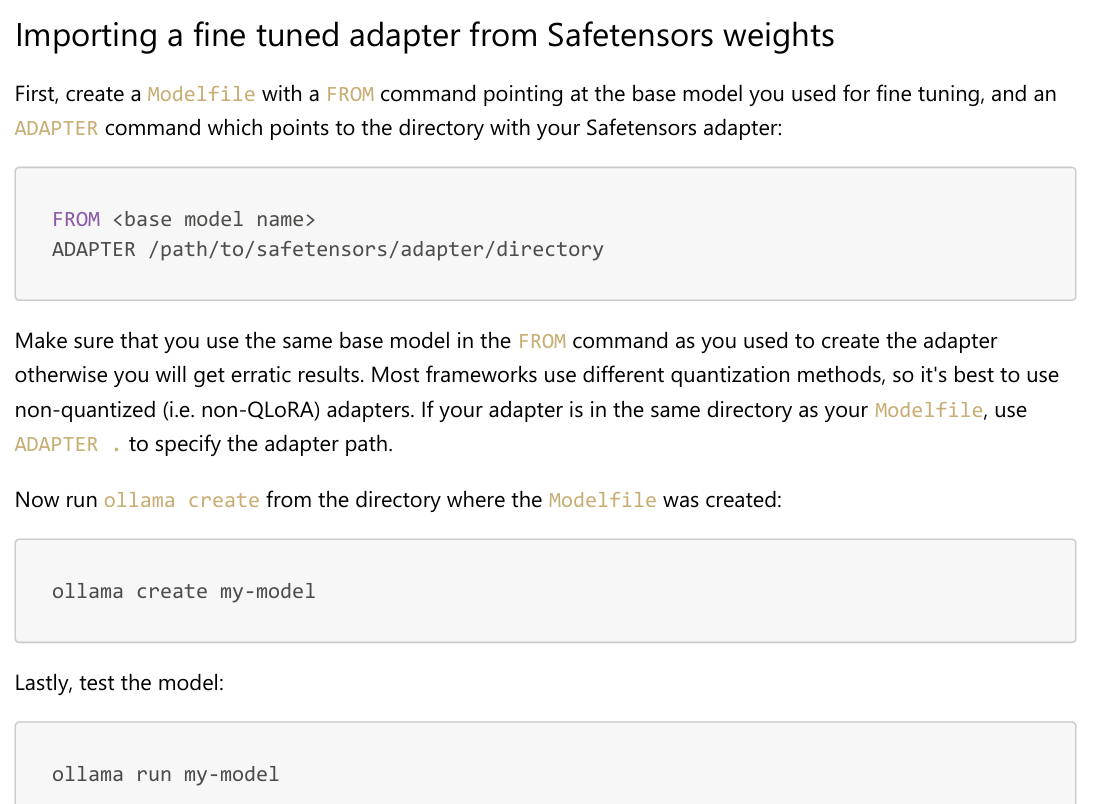

### 从上面可以看到，在创建的safetensors文件类型的文件夹中创建一个名字叫：ModelFile的文件，没有后缀名，然后From命令后面的是在Ollama中pull的原始的模型（微调前），然后ADAPTER . 表示我的Lora的微调的结果在同一文件夹

### 现在进行gradio的编写

In [15]:
import gradio as gr
import requests
import json

In [16]:
model_name = "my_tiny_llama:latest"
ollama_url = "http://localhost:11434/api/chat"

In [21]:
def chat_with_self_tiny_llama(user_input, chat_history):
    messages = []

    for user, bot in chat_history:
        messages.append({"role": "user", "content": user})
        messages.append({"role": "assistant", "content": bot})

    messages.append({"role": "user", "content": user_input})

    response = requests.post(ollama_url, json={
        "model":model_name,
        "messages":messages
    }, stream=True)

    reply_message = ""

    for line in response.iter_lines():
        if line:
            chunks = json.loads(line.decode("utf-8"))
            content = chunks.get("message", {}).get("content", "")
            reply_message += content
            
            yield chat_history + [(user_input, reply_message)] 

In [22]:
def reset_chat_history():
    return []

In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("## This the model after fine-tune")

    chat_bot = gr.Chatbot()
    user_input = gr.Textbox(placeholder="Please input text here")
    submit_button = gr.Button(value="Send Request")
    reset_button = gr.Button(value="Reset Chat History")
    submit_button.click(
        fn=chat_with_self_tiny_llama,
        inputs=[user_input, chat_bot],
        outputs=chat_bot
    ).then(fn=lambda:"", inputs=[], outputs=user_input)

    reset_button.click(
        fn=reset_chat_history,
        outputs=chat_bot
    )

demo.launch()